Fashion MNIST Classification:

In [2]:
!pip install -q torchinfo

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import torchvision
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import time

Set seed for reproducibility

In [5]:
def seed_values():
  SEED_VALUE=42
  np.random.seed(SEED_VALUE)
  random.seed(SEED_VALUE)
  torch.manual_seed(SEED_VALUE)

  if torch.cuda.is_available():
       torch.cuda.manual_seed(SEED_VALUE)
       torch.cuda.manual_seed_all(SEED_VALUE)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = True

seed_values()

 Prepare the DataLoader

In [7]:
raw_transform=transforms.Compose([transforms.ToTensor()])
train_set_raw=datasets.FashionMNIST(root="F_MNIST_data", download=True, train=True, transform=raw_transform)

all_pixels = torch.cat([img.view(-1) for img, _ in train_set_raw])
mean = all_pixels.mean().item()
std = all_pixels.std().item()

print(f"Computed Mean: {mean:.4f}, Computed Std: {std:.4f}")

100%|██████████| 26.4M/26.4M [00:01<00:00, 22.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 339kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.08MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.2MB/s]


Computed Mean: 0.2860, Computed Std: 0.3530


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_set = datasets.FashionMNIST(root="F_MNIST_data", download=True, train=True, transform=transform)
val_set = datasets.FashionMNIST(root="F_MNIST_data", download=True, train=False, transform=transform)  # Test set

print("Total Train Images:", len(train_set))
print("Total Val Images:", len(val_set))

Total Train Images: 60000
Total Val Images: 10000


In [9]:
train_loader=torch.utils.data.DataLoader(train_set,shuffle=True,batch_size=64)
val_loader=torch.utils.data.DataLoader(val_set,shuffle=False,batch_size=64)

The Fashion MNIST contains 10 classes as follows:

| Label | Description   |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |


In [10]:
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"  }

Dataset Visualization

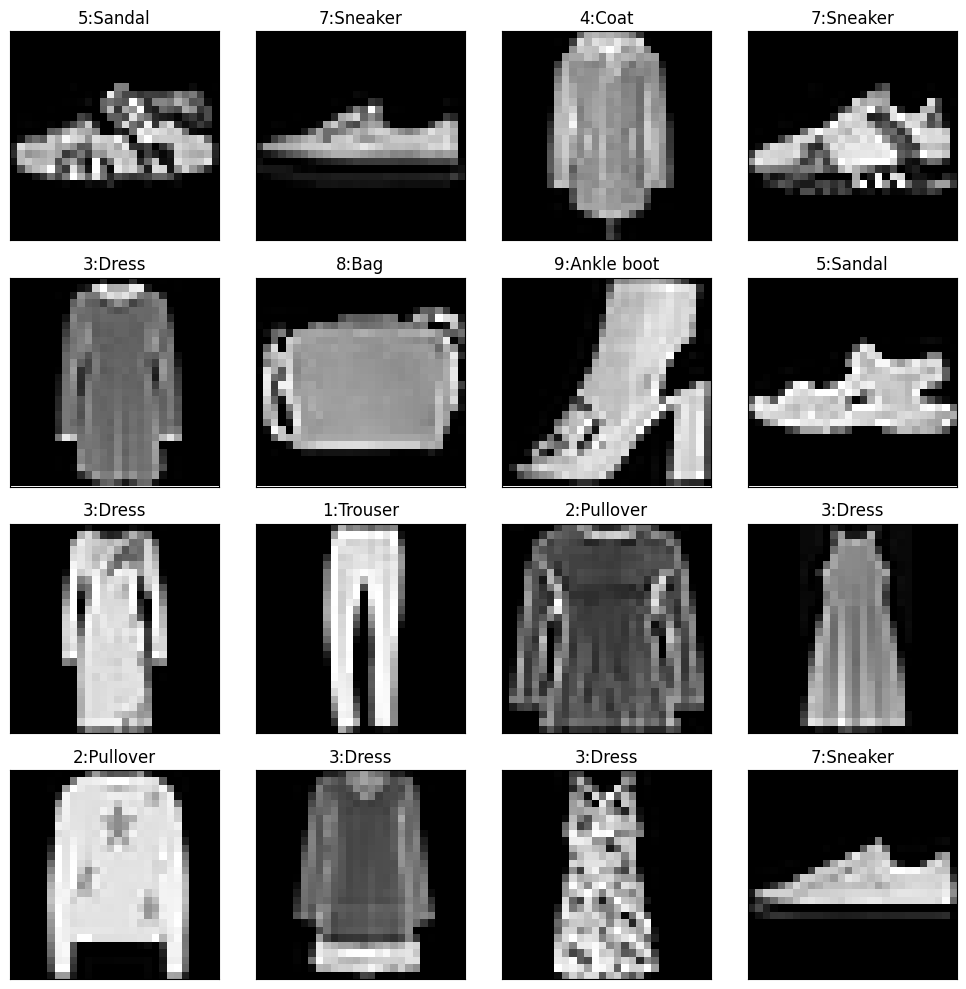

In [11]:
def visualize_images(trainloader, num_images=20):
    fig = plt.figure(figsize=(10, 10))

    images, labels = next(iter(trainloader))

    num_rows = 4
    num_cols = int(np.ceil(num_images / num_rows))

    for idx in range(min(num_images, len(images))):
      image, label = images[idx], labels[idx]

      ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(image), cmap="gray")
      ax.set_title(f"{label.item()}:{class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

visualize_images(train_loader, num_images=16)

Deep Neural Network Architecture:
The network architecture shown below has multiple layers. An input layer, five hidden layers, and an output layer. There are several things to note about this architecture.

*   Input Data: The image input data is pre-processed (flattened) from a 2-Dimensional array [28x28] to 1-Dimensional vector of length [784x1] where the elements in this input vector are the normalized pixel intensities.

*   Hidden Layers: We have five hidden layers that contain some number of neurons (that we need to specify). Each of the neurons in these layers has a non-linear activation function (e.g., ReLU, Sigmoid, etc.).

*  Output Layer: We now have ten neurons in the output layer to represent the ten different classes (cloth items: 0 to 9), instead of a single neuron as in the regression example.

*   Dense Layers: All the layers in the network are fully connected, meaning that each neuron in a given layer is fully connected (or dense) to each of the neurons in the previous layer. The weights associated with each layer are represented in bold to indicate that these are matrices that contain each of the weights for all the connections between adjacent layers in the network.

*   Network Output: The network output ( y′ ), is a vector of length ten, that contains the probabilities of each output neuron. Predicting the class label simply requires passing ( y′ ) through the argmax function to determine the index of the predicted label.

*  Softmax Function: The values from each of the neurons in the output layer are pased through a log_softmax() function to produce a probability score for each of the ten cloth items in the dataset.

*   Loss Function: The loss function used is Negative Log Likelihood Loss. It is computed from the ground truth labels ( y ) and the output log probabilities of the network ( y′ ). Note that  y  and  y′  are both matrices whose shape is (Bacth Size, Num Classes).









MLP

In [13]:
class MLP(nn.Module):
  def __init__(self,num_classes):
    super().__init__()
    self.fc0 = nn.Linear(784, 512)
    self.bn0 = nn.BatchNorm1d(512)
    self.fc1 = nn.Linear(512, 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.fc2 = nn.Linear(256, 128)
    self.bn2 = nn.BatchNorm1d(128)
    self.fc3 = nn.Linear(128, 64)
    self.bn3 = nn.BatchNorm1d(64)
    self.fc4 = nn.Linear(64,num_classes)

    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
      x = x.view(x.shape[0], -1)
      x = F.relu(self.bn0(self.fc0(x)))
      x = self.dropout(x)

      x = F.relu(self.bn1(self.fc1(x)))

      x = F.relu(self.bn2(self.fc2(x)))
      x = self.dropout(x)
      x = F.relu(self.bn3(self.fc3(x)))
      x = F.log_softmax(self.fc4(x), dim = 1)

      return x


mlp_model = MLP(num_classes = 10)


In [14]:
print(summary(mlp_model, input_size = (1,1,28,28), row_settings = ["var_names"]))

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bn0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 256]                  131,328
├─BatchNorm1d (bn1)                      [1, 256]                  512
├─Linear (fc2)                           [1, 128]                  32,896
├─BatchNorm1d (bn2)                      [1, 128]                  256
├─Dropout (dropout)                      [1, 128]                  --
├─Linear (fc3)                           [1, 64]                   8,256
├─BatchNorm1d (bn3)                      [1, 64]                   128
├─Linear (fc4)                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable

Model Training

In [17]:
criterion = F.nll_loss
optimizer = optim.Adam(mlp_model.parameters(), lr = 1e-2)
num_epochs = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
def training(model,trainloader,criterion,optimizer,DEVICE):
  model.train()
  model.to(DEVICE)
  running_loss = 0
  correct_predictions = 0
  total_samples = 0
  for images, labels in trainloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

  avg_loss = running_loss / len(trainloader)
  accuracy = 100 * correct_predictions / total_samples
  return avg_loss, accuracy


In [19]:
def validation(model, val_loader, criterion,DEVICE):
    model.eval()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images,labels = images.to(DEVICE),labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [26]:
def main(model, trainloader, val_loader, epochs=5, DEVICE = "cuda"):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_accuracy = training(model, trainloader, criterion, optimizer, DEVICE)
        val_loss, val_accuracy = validation(model, val_loader, criterion, DEVICE)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1:0>2}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Epoch 01/40 - Train Loss: 0.5663, Train Accuracy: 79.89% - Val Loss: 0.4388, Val Accuracy: 84.43%
Epoch 02/40 - Train Loss: 0.4382, Train Accuracy: 84.34% - Val Loss: 0.3816, Val Accuracy: 86.06%
Epoch 03/40 - Train Loss: 0.3986, Train Accuracy: 85.66% - Val Loss: 0.3816, Val Accuracy: 86.24%
Epoch 04/40 - Train Loss: 0.3709, Train Accuracy: 86.72% - Val Loss: 0.3763, Val Accuracy: 86.40%
Epoch 05/40 - Train Loss: 0.3533, Train Accuracy: 87.27% - Val Loss: 0.3459, Val Accuracy: 87.49%
Epoch 06/40 - Train Loss: 0.3362, Train Accuracy: 87.91% - Val Loss: 0.3372, Val Accuracy: 87.68%
Epoch 07/40 - Train Loss: 0.3257, Train Accuracy: 88.16% - Val Loss: 0.3417, Val Accuracy: 87.64%
Epoch 08/40 - Train Loss: 0.3136, Train Accuracy: 88.58% - Val Loss: 0.3207, Val Accuracy: 88.47%
Epoch 09/40 - Train Loss: 0.3022, Train Accuracy: 88.94% - Val Loss: 0.3445, Val Accuracy: 87.63%
Epoch 10/40 - Train Loss: 0.2935, Train Accuracy: 89.35% - Val Loss: 0.3236, Val Accuracy: 88.23%
Epoch 11/40 - Train 

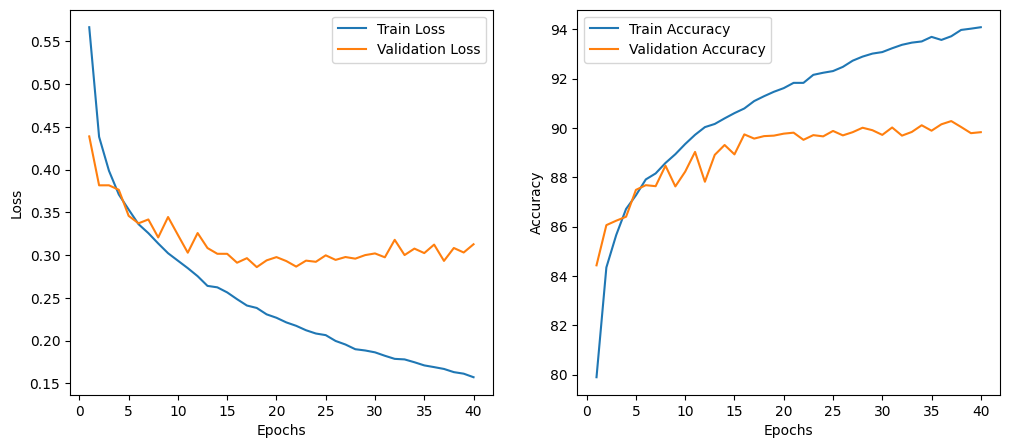

In [27]:
main(mlp_model, train_loader, val_loader, epochs = num_epochs, DEVICE = DEVICE)

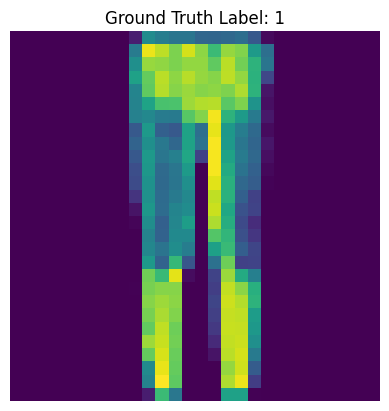

In [29]:
images, gt_labels = next(iter(val_loader))

rand_idx = random.choice(range(len(images)))

plt.imshow(images[rand_idx].squeeze())
plt.title("Ground Truth Label: " + str(int(gt_labels[rand_idx])), fontsize = 12)
plt.axis("off")
plt.show()

In [30]:
bold = f"\033[1m"
reset = f"\033[0m"

In [31]:
mlp_model.eval()

with torch.no_grad():
     batch_outputs = mlp_model(images.to(DEVICE))

prob_score_batch = batch_outputs.softmax(dim=1).cpu()

prob_score_test_image = prob_score_batch[rand_idx]
pred_cls_id = prob_score_test_image.argmax()

print("Predictions for each class on the test image:\n")

for idx, cls_prob in enumerate(prob_score_test_image):
    if idx == pred_cls_id:
       print(f"{bold}Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}{reset}")
    else:
       print(f"Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}")

Predictions for each class on the test image:

Class: 0 - T-shirt/top, Probability: 0.000
Class: 1 - Trouser, Probability: 1.000
Class: 2 - Pullover, Probability: 0.000
Class: 3 - Dress, Probability: 0.000
Class: 4 - Coat, Probability: 0.000
Class: 5 - Sandal, Probability: 0.000
Class: 6 - Shirt, Probability: 0.000
Class: 7 - Sneaker, Probability: 0.000
Class: 8 - Bag, Probability: 0.000
Class: 9 - Ankle boot, Probability: 0.000


In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [33]:
def prediction_batch(model, batch_inputs):
    model.eval()

    batch_outputs = model(batch_inputs)

    with torch.no_grad():
        batch_probs = batch_outputs.softmax(dim=1) #along num of classes dimension

    batch_cls_ids = batch_probs.argmax(dim=1)

    return batch_cls_ids.cpu()

In [34]:
val_target_labels = []
val_predicted_labels = []

for image_batch, target_batch in val_loader:
    image_batch = image_batch.to(DEVICE)

    batch_pred_cls_id = prediction_batch(mlp_model, image_batch)

    val_predicted_labels.append(batch_pred_cls_id)
    val_target_labels.append(target_batch)

val_target_labels = torch.cat(val_target_labels).numpy()
val_predicted_labels = torch.cat(val_predicted_labels).numpy()

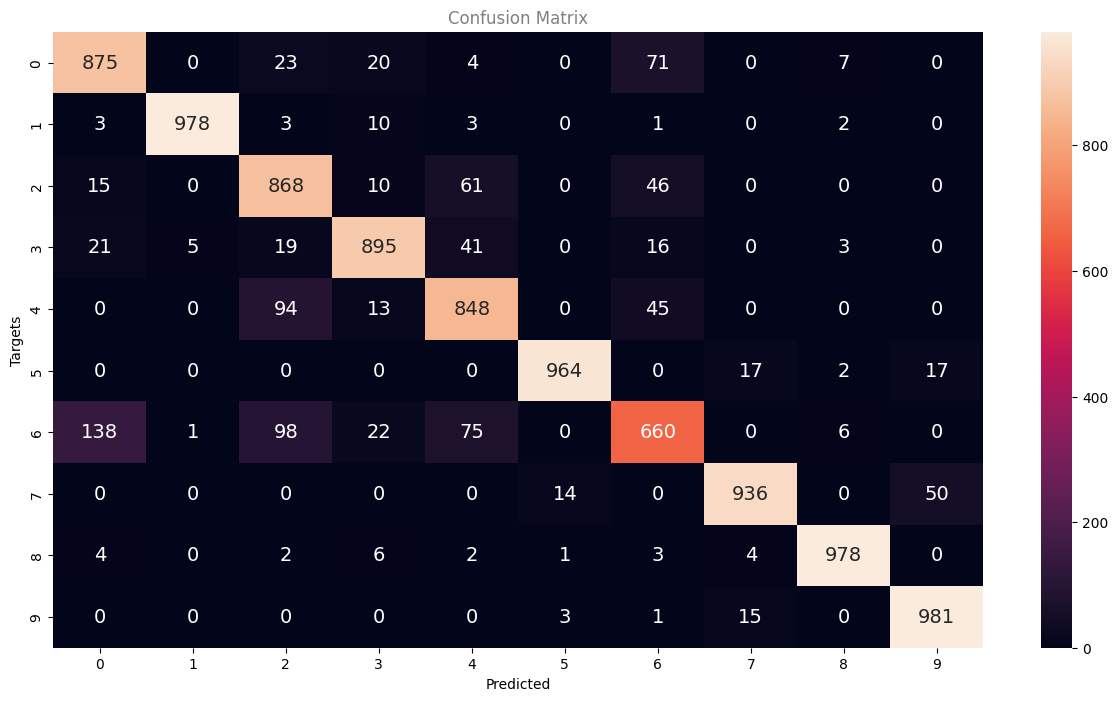

In [35]:
cm = confusion_matrix(y_true=val_target_labels, y_pred = val_predicted_labels)

plt.figure(figsize= [15,8])

sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size":14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confusion Matrix", color="gray")
plt.show()